In [1]:
# import Libraries

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# Get Data from finviz using 'https://finviz.com/quote.ashx?t='

finviz_url = 'https://finviz.com/quote.ashx?t='

In [5]:
# Apple, Amazon, Google, Meta, and Microsoft

tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT']

In [7]:
def TickerData(tickers):
    news_tables = {}
    for ticker in tickers:
        url = finviz_url + ticker
        req = Request(url=url, headers={'user-agent': 'my-app'})
        response = urlopen(req)

        html = BeautifulSoup(response, features='html.parser')
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table

    return news_tables

In [9]:
# Get raw data on arcticles written about companies in tickers using TickerData() function

NewsTables = TickerData(tickers)

In [11]:
def TickerTable(newstable):
    
    parsed_data = []
    
    for ticker, news_table in newstable.items():
        for row in news_table.findAll('tr'):
            title = row.a.text
            date_data = row.td.text.split()

            if len(date_data) == 1:
                time = date_data[0]
            else:
                date = date_data[0]
                time = date_data[1]

            parsed_data.append([ticker, date, time, title])
            
    return parsed_data

In [13]:
# Get 'ticker', 'date', 'time', 'title' data from raw data on arcticles written about companies in tickers using TickerTable() function

ParsedData = TickerTable(NewsTables)

In [15]:
df = pd.DataFrame(ParsedData, columns=['ticker', 'date', 'time', 'title'])

In [17]:
df

,ticker,date,time,title
0,AAPL,Today,10:14AM,"Apple, Amazon Results Are Crucial for Nasdaq 1..."
1,AAPL,Today,10:07AM,"Apple Has Been Outperforming Nvidia, Other Big..."
2,AAPL,Today,09:59AM,Apple set to report earnings: Here's what to e...
3,AAPL,Today,09:47AM,Qualcomm Is Betting on AI Smartphones for Grow...
4,AAPL,Today,08:26AM,How To Earn $500 A Month From Apple Stock Ahea...
...,...,...,...,...
495,MSFT,Jul-30-24,05:35PM,S&P 500 Gains and Losses Today: Merck Stock Pl...
496,MSFT,Jul-30-24,05:29PM,Microsoft stock is falling after an AI sales d...
497,MSFT,Jul-30-24,05:26PM,A Microsoft Bull Got Some of What He Wanted bu...
498,MSFT,Jul-30-24,05:15PM,Microsoft (MSFT) Tops Q4 Earnings and Revenue ...


In [19]:
vader = SentimentIntensityAnalyzer()

In [21]:
# use polarity_scores in SentimentIntensityAnalyzer() to calculate a compound score on whether the title for the articles were 
# positive or negative and give a numeric score
 
f = lambda title: vader.polarity_scores(title)['compound']

In [23]:
# add the compound score for each title in a new column called 'compound'

df['compound'] = df['title'].apply(f)

In [25]:
df

,ticker,date,time,title,compound
0,AAPL,Today,10:14AM,"Apple, Amazon Results Are Crucial for Nasdaq 1...",0.1779
1,AAPL,Today,10:07AM,"Apple Has Been Outperforming Nvidia, Other Big...",0.0000
2,AAPL,Today,09:59AM,Apple set to report earnings: Here's what to e...,0.0000
3,AAPL,Today,09:47AM,Qualcomm Is Betting on AI Smartphones for Grow...,0.1027
4,AAPL,Today,08:26AM,How To Earn $500 A Month From Apple Stock Ahea...,0.0000
...,...,...,...,...,...
495,MSFT,Jul-30-24,05:35PM,S&P 500 Gains and Losses Today: Merck Stock Pl...,-0.3400
496,MSFT,Jul-30-24,05:29PM,Microsoft stock is falling after an AI sales d...,-0.5994
497,MSFT,Jul-30-24,05:26PM,A Microsoft Bull Got Some of What He Wanted bu...,0.0000
498,MSFT,Jul-30-24,05:15PM,Microsoft (MSFT) Tops Q4 Earnings and Revenue ...,0.5106


In [27]:
# replace 'Today' in date column to today's date

today = date.today()
toDay = today.strftime("%b-%d-%y")

In [29]:
df['date'] = df['date'].replace('Today', toDay)
df['date'] = pd.to_datetime(df.date).dt.date 

/var/folders/_b/hddzz3w53xsbp30px8yqb0900000gn/T/ipykernel_10153/3136663125.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.date).dt.date


In [31]:
# Find the average of the compound score of the articles for each day, for each company 

mean_df = df.groupby(['ticker', 'date']).mean(numeric_only = True)
mean_df = mean_df.unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose()

In [33]:
mean_df

ticker,AAPL,AMZN,GOOG,META,MSFT
date,,,,,
2024-07-27,NaN,0.223280,NaN,NaN,NaN
2024-07-28,0.094960,0.177707,NaN,NaN,NaN
2024-07-29,0.027742,0.076035,0.088233,NaN,NaN
2024-07-30,0.100879,0.103415,0.095039,0.089736,-0.021876
2024-07-31,0.075538,0.318982,0.133647,0.107755,0.084268
2024-08-01,0.177143,0.092053,0.147833,0.119982,0.042300


<Figure size 1000x800 with 0 Axes>

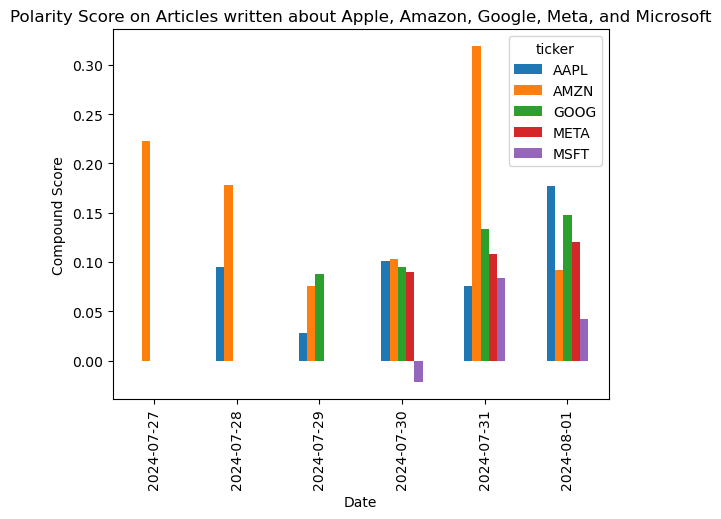

In [35]:
# Plot a bar chart

plt.figure(figsize=(10,8))
mean_df.plot(kind='bar')
plt.title('Polarity Score on Articles written about Apple, Amazon, Google, Meta, and Microsoft')
plt.xlabel('Date')
plt.ylabel('Compound Score')
plt.show()